## Import lib

In [1]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
! pip install torchsummary
import torchsummary



# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import seaborn as sns

## Create dataframes

In [2]:
train_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
train_path = '/kaggle/input/fundus-pytorch/train'
folder_list = os.listdir(train_path)
label_map = {
    "0":"Glaucoma Present", 
    "1":"Glaucoma not Present",
}
for folder in label_map:
    img_path = os.path.join(train_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        train_df = pd.concat([train_df, new_data], ignore_index=True)

train_df[["path"]] = train_df[["path"]].astype(str)
train_df[["label"]] = train_df[["label"]].astype(str)
train_df[["class_id"]] = train_df[["class_id"]].astype(int)



In [3]:
val_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
val_path = '/kaggle/input/fundus-pytorch/val'
for folder in label_map:
    img_path = os.path.join(val_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        val_df = pd.concat([val_df, new_data], ignore_index=True)

val_df[["path"]] = val_df[["path"]].astype(str)
val_df[["label"]] = val_df[["label"]].astype(str)
val_df[["class_id"]] = val_df[["class_id"]].astype(int)

In [4]:
test_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
test_path = '/kaggle/input/fundus-pytorch/test'
for folder in label_map:
    img_path = os.path.join(test_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        test_df = pd.concat([test_df, new_data], ignore_index=True)

test_df[["path"]] = test_df[["path"]].astype(str)
test_df[["label"]] = test_df[["label"]].astype(str)
test_df[["class_id"]] = test_df[["class_id"]].astype(int)

In [5]:
train_df.head()

,path,label,class_id
0,/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...,Glaucoma Present,0
1,/kaggle/input/fundus-pytorch/train/0/REFUGE1-t...,Glaucoma Present,0
2,/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...,Glaucoma Present,0
3,/kaggle/input/fundus-pytorch/train/0/PAPILA-38...,Glaucoma Present,0
4,/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...,Glaucoma Present,0


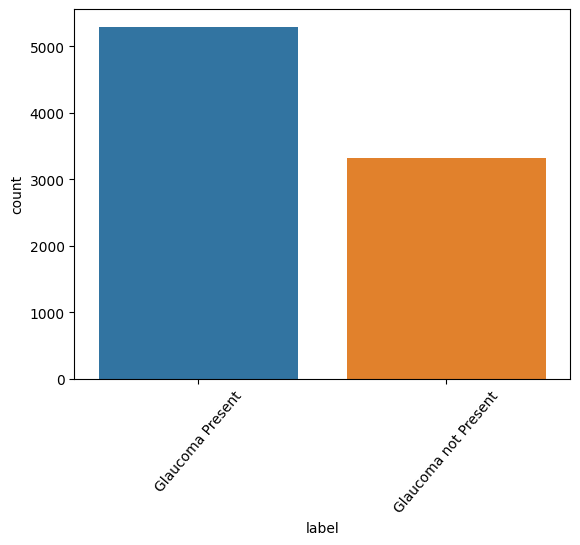

In [6]:
sns.countplot(x = train_df["label"])
plt.xticks(rotation = 50);

## Show images

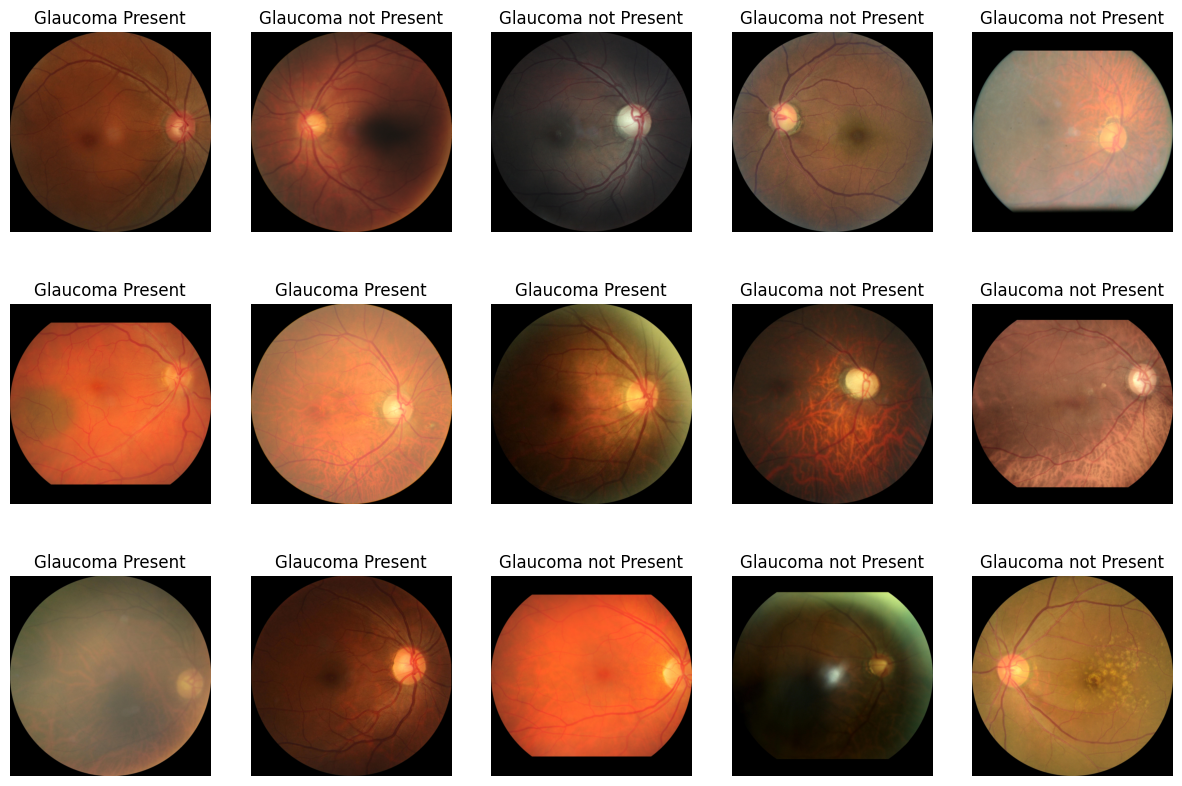

In [7]:
show_imgs = 15
idx = np.random.randint(0, len(train_df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = train_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(train_df.loc[idx[i]]['label'])
    ax.set_axis_off()

## Create dataset and dataloader

In [8]:
train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    # v2.RandomRotation(degrees=(-20, 20)),
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [9]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']
        # img = Image.open(image_path).convert("LA")
        img = Image.open(image_path).convert("RGB")
        # img = Image.open(image_path)
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

In [10]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
num_workers = 2 if device=='cuda' else 4 # fixed by kaggle notebook
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)
test_dataset = MyDataset(test_df, test_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [11]:
print(f'train data:{len(train_df)}')
print(f'val data:{len(val_df)}')

train data:8621
val data:5747


## Create model

In [12]:
class_size = 2
# model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
model = models.efficientnet_v2_s(weights='DEFAULT')
# model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1] = torch.nn.Linear(1280, class_size)
model(torch.randn((16,3,256,256))).shape

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 135MB/s] 


torch.Size([16, 2])

## Traning and validation

In [13]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0 
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)
        
        # First we'll clean the cache of optimizer
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(data_)
        
        # Computing loss 
        loss = loss_fn(outputs,target_)
        
        # Backward propagation
        loss.backward()
        
        # Optimizing model
        optimizer.step()
        
        # Computing statistics.
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    lr_scheduler.step()
    return epoch_correct/size, epoch_loss/num_batches


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    epoch_loss = 0.0
    epoch_correct = 0 
    with torch.no_grad():
        # This will disable backward propagation
        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # Forward propagation
            outputs = model(data_)
            
            # Computing loss 
            loss = loss_fn(outputs,target_)
            # Computing statistics.
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return  epoch_correct/size, epoch_loss/num_batches

In [14]:
model.to(device)
EPOCHS = 30

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")
    
criterion  = nn.CrossEntropyLoss()


# Optimizer which will use gradients to train model.
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
lr_milestones = [7, 14, 21, 28, 35]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

best_model_path = "/kaggle/working/best_model.pth"  # Define the path where you want to save the best model

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, multi_step_lr_scheduler)
    val_acc, val_loss = test(val_loader, model, criterion)
    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} \
    Learning Rate: {optimizer.param_groups[0]["lr"]}')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    torch.save(model.state_dict(), "checkpoints/last.pth")

    # Check for improvement in validation loss
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the best model
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

# Load the best model before evaluating
model.load_state_dict(torch.load(best_model_path))

  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 0.5067, train_acc: 0.747     val_loss: 0.3494, val_acc: 0.862     Learning Rate: 0.0001


  3%|▎         | 1/30 [06:43<3:15:04, 403.61s/it]

EPOCH: 1     train_loss: 0.4058, train_acc: 0.818     val_loss: 0.3177, val_acc: 0.864     Learning Rate: 0.0001


  7%|▋         | 2/30 [11:12<2:31:26, 324.53s/it]

EPOCH: 2     train_loss: 0.3732, train_acc: 0.836     val_loss: 0.2631, val_acc: 0.895     Learning Rate: 0.0001


 10%|█         | 3/30 [15:38<2:14:01, 297.82s/it]

EPOCH: 3     train_loss: 0.3575, train_acc: 0.845     val_loss: 0.2334, val_acc: 0.906     Learning Rate: 0.0001


 13%|█▎        | 4/30 [20:06<2:03:50, 285.78s/it]

EPOCH: 4     train_loss: 0.3374, train_acc: 0.851     val_loss: 0.2397, val_acc: 0.896     Learning Rate: 0.0001


 17%|█▋        | 5/30 [24:32<1:56:06, 278.67s/it]

EPOCH: 5     train_loss: 0.3295, train_acc: 0.855     val_loss: 0.2432, val_acc: 0.907     Learning Rate: 0.0001


 20%|██        | 6/30 [29:01<1:50:09, 275.40s/it]

EPOCH: 6     train_loss: 0.3189, train_acc: 0.860     val_loss: 0.2012, val_acc: 0.917     Learning Rate: 1e-05


 23%|██▎       | 7/30 [33:28<1:44:30, 272.63s/it]

EPOCH: 7     train_loss: 0.2862, train_acc: 0.872     val_loss: 0.1887, val_acc: 0.922     Learning Rate: 1e-05


 27%|██▋       | 8/30 [37:56<1:39:26, 271.19s/it]

EPOCH: 8     train_loss: 0.2784, train_acc: 0.880     val_loss: 0.1802, val_acc: 0.926     Learning Rate: 1e-05


 30%|███       | 9/30 [42:27<1:34:56, 271.27s/it]

EPOCH: 9     train_loss: 0.2729, train_acc: 0.881     val_loss: 0.1769, val_acc: 0.929     Learning Rate: 1e-05


 33%|███▎      | 10/30 [46:57<1:30:18, 270.94s/it]

EPOCH: 10     train_loss: 0.2698, train_acc: 0.883     val_loss: 0.1711, val_acc: 0.931     Learning Rate: 1e-05


 37%|███▋      | 11/30 [51:25<1:25:27, 269.86s/it]

EPOCH: 11     train_loss: 0.2610, train_acc: 0.885     val_loss: 0.1665, val_acc: 0.934     Learning Rate: 1e-05


 40%|████      | 12/30 [55:52<1:20:45, 269.18s/it]

EPOCH: 12     train_loss: 0.2582, train_acc: 0.889     val_loss: 0.1622, val_acc: 0.935     Learning Rate: 1e-05


 43%|████▎     | 13/30 [1:00:19<1:16:00, 268.28s/it]

EPOCH: 13     train_loss: 0.2507, train_acc: 0.890     val_loss: 0.1563, val_acc: 0.939     Learning Rate: 1.0000000000000002e-06


 47%|████▋     | 14/30 [1:04:46<1:11:29, 268.11s/it]

EPOCH: 14     train_loss: 0.2479, train_acc: 0.894     val_loss: 0.1562, val_acc: 0.937     Learning Rate: 1.0000000000000002e-06


 50%|█████     | 15/30 [1:09:14<1:06:58, 267.93s/it]

EPOCH: 15     train_loss: 0.2476, train_acc: 0.894     val_loss: 0.1576, val_acc: 0.936     Learning Rate: 1.0000000000000002e-06


 53%|█████▎    | 16/30 [1:13:43<1:02:35, 268.25s/it]

EPOCH: 16     train_loss: 0.2422, train_acc: 0.895     val_loss: 0.1547, val_acc: 0.938     Learning Rate: 1.0000000000000002e-06


 57%|█████▋    | 17/30 [1:18:12<58:11, 268.60s/it]  

EPOCH: 17     train_loss: 0.2493, train_acc: 0.892     val_loss: 0.1527, val_acc: 0.939     Learning Rate: 1.0000000000000002e-06


 60%|██████    | 18/30 [1:22:41<53:44, 268.73s/it]

EPOCH: 18     train_loss: 0.2440, train_acc: 0.898     val_loss: 0.1557, val_acc: 0.936     Learning Rate: 1.0000000000000002e-06


 63%|██████▎   | 19/30 [1:27:10<49:16, 268.79s/it]

EPOCH: 19     train_loss: 0.2477, train_acc: 0.892     val_loss: 0.1568, val_acc: 0.935     Learning Rate: 1.0000000000000002e-06


 67%|██████▋   | 20/30 [1:31:37<44:41, 268.17s/it]

EPOCH: 20     train_loss: 0.2428, train_acc: 0.895     val_loss: 0.1510, val_acc: 0.940     Learning Rate: 1.0000000000000002e-07


 70%|███████   | 21/30 [1:36:04<40:09, 267.67s/it]

EPOCH: 21     train_loss: 0.2403, train_acc: 0.893     val_loss: 0.1504, val_acc: 0.939     Learning Rate: 1.0000000000000002e-07


 73%|███████▎  | 22/30 [1:40:29<35:35, 266.91s/it]

EPOCH: 22     train_loss: 0.2390, train_acc: 0.895     val_loss: 0.1519, val_acc: 0.939     Learning Rate: 1.0000000000000002e-07


 77%|███████▋  | 23/30 [1:44:53<31:03, 266.19s/it]

EPOCH: 23     train_loss: 0.2389, train_acc: 0.899     val_loss: 0.1523, val_acc: 0.940     Learning Rate: 1.0000000000000002e-07


 80%|████████  | 24/30 [1:49:18<26:35, 265.88s/it]

EPOCH: 24     train_loss: 0.2420, train_acc: 0.891     val_loss: 0.1551, val_acc: 0.937     Learning Rate: 1.0000000000000002e-07


 83%|████████▎ | 25/30 [1:53:45<22:10, 266.18s/it]

EPOCH: 25     train_loss: 0.2379, train_acc: 0.897     val_loss: 0.1516, val_acc: 0.939     Learning Rate: 1.0000000000000002e-07


 87%|████████▋ | 26/30 [1:58:10<17:43, 265.86s/it]

EPOCH: 26     train_loss: 0.2429, train_acc: 0.893     val_loss: 0.1511, val_acc: 0.938     Learning Rate: 1.0000000000000002e-07


 87%|████████▋ | 26/30 [2:02:36<18:51, 282.92s/it]

Earlystop!


<All keys matched successfully>

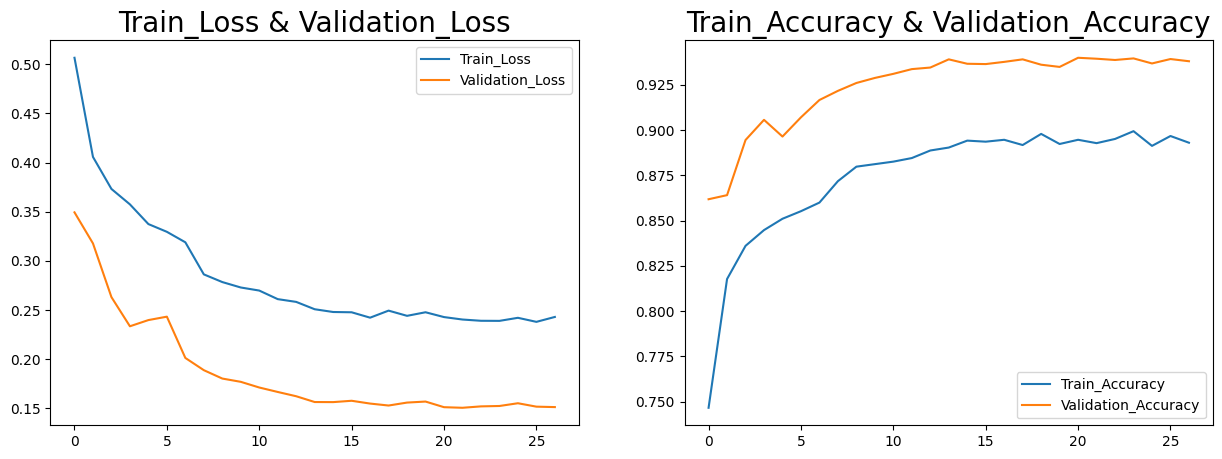

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'],label='Train_Accuracy')
plt.plot(logs['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

## Metrics

In [17]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for (data_,target_) in tqdm(test_loader):
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)
        outputs = model(data_)
        _,pred = torch.max(outputs,dim=1)
        y_true.extend(target_.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)


100%|██████████| 90/90 [01:03<00:00,  1.42it/s]


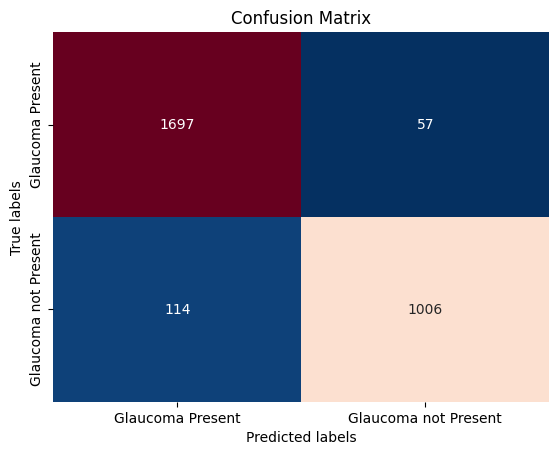

In [18]:
label_list = ["Glaucoma Present", "Glaucoma not Present"]
ax= plt.subplot()
CM = confusion_matrix(y_true,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False,cmap='RdBu_r',
            xticklabels= label_list, yticklabels=label_list)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()

In [19]:
clf_report = classification_report(y_true, y_pred, target_names = label_list)
print(clf_report)

                      precision    recall  f1-score   support

    Glaucoma Present       0.94      0.97      0.95      1754
Glaucoma not Present       0.95      0.90      0.92      1120

            accuracy                           0.94      2874
           macro avg       0.94      0.93      0.94      2874
        weighted avg       0.94      0.94      0.94      2874

